<a href="https://colab.research.google.com/github/stevengregori92/Try-XGB-RF-KNN-and-SVM/blob/main/Try_XGB%2C_RF%2C_KNN%2C_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install luwiji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.5 MB/s eta 0:00:00
  Created wheel for luwiji: filename=luwiji-1.2.1-py2.py3-none-any.whl size=40366842 sha256=caf119b556c348519bf3d3c0c7bbba6975bff6a8fea486c0a47aafcbd32bab07
  Stored in directory: /root/.cache/pip/wheels/1b/49/54/8dfa7de82599da47df8c290f769ade64075dc7a0a2a4fd7414
  Created wheel for jcopml: filename=jcopml-1.2.2-py2.py3-none-any.whl size=32194 sha256=bcf5737b83c2c1a9696aae14f567f7d3f9e18588f92d469c1b2abfa70436647a
  Stored in directory: /root/.cache/pip/wheels/a6/1c/91/32f7a6b0a9d6bbcef17a7fc0d065f9a9b8d9904551b377b64d
Successfully built luwiji jcopml


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

#Import Dataset

In [3]:
data = pd.read_csv('google-stock-dataset-Daily.csv', index_col='Unnamed: 0')
data

,Date,Price,High,Low,Close,Volume,Adj Close
0,2013-04-15,19.67,19.94,19.44,19.57,98025876,19.57
1,2013-04-16,19.68,19.92,19.62,19.85,69610320,19.85
2,2013-04-17,19.69,19.79,19.47,19.58,81398520,19.58
3,2013-04-18,19.65,19.66,19.05,19.17,132767100,19.17
4,2013-04-19,19.25,20.11,19.18,20.02,231895872,20.02
...,...,...,...,...,...,...,...
2505,2023-03-27,104.62,104.76,101.93,102.46,31120900,102.46
2506,2023-03-28,102.44,102.45,99.74,101.03,32057900,101.03
2507,2023-03-29,102.28,102.49,100.65,101.39,28779600,101.39
2508,2023-03-30,100.91,101.16,99.78,100.89,33086200,100.89


#Explore Dataset

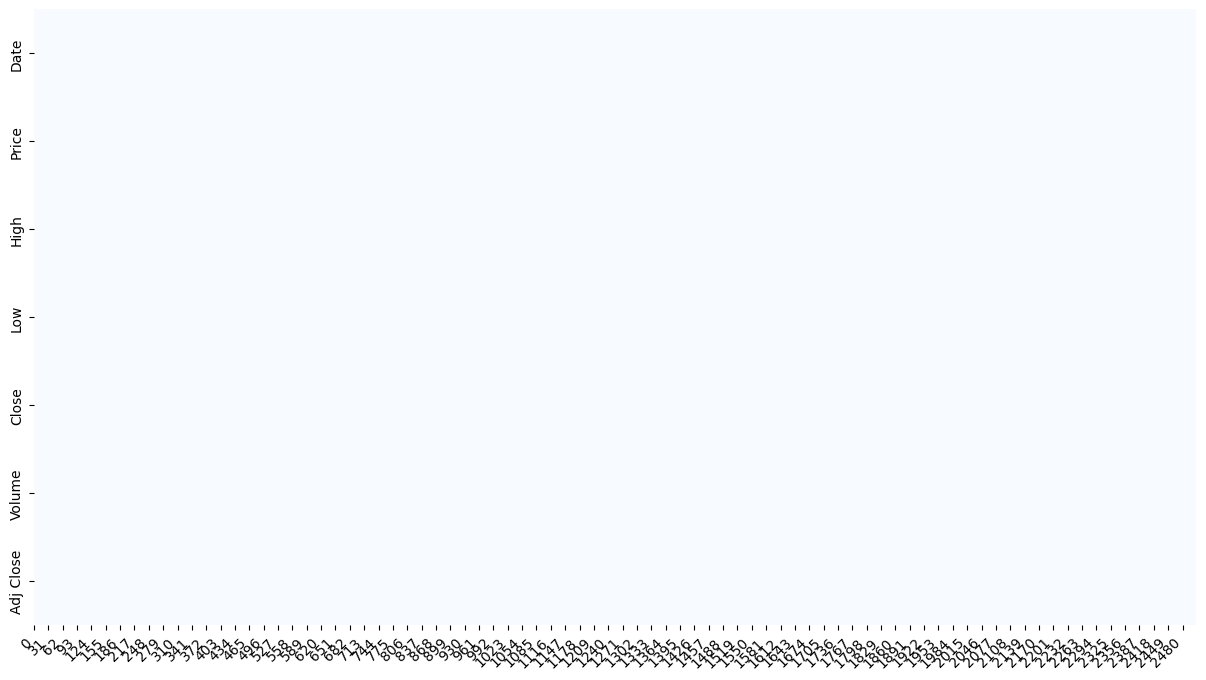

In [4]:
plot_missing_value(data)

In [5]:
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2510 entries, 0 to 2509
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2510 non-null   datetime64[ns]
 1   Price      2510 non-null   float64       
 2   High       2510 non-null   float64       
 3   Low        2510 non-null   float64       
 4   Close      2510 non-null   float64       
 5   Volume     2510 non-null   int64         
 6   Adj Close  2510 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 221.4 KB


In [6]:
data['Date'] = data['Date'].dt.year

#Data Split

In [7]:
X = data.drop(columns=['Price'])
y = data.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2008, 6), (502, 6), (2008,), (502,))

#Training with XGBoost

In [8]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [9]:
X_train.columns

Index(['Date', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [10]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['High', 'Low', 'Close', 'Volume', 'Adj Close'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs = -1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

{'algo__colsample_bytree': 0.7545447962707789, 'algo__gamma': 8, 'algo__learning_rate': 0.13832094546570484, 'algo__max_depth': 9, 'algo__n_estimators': 161, 'algo__reg_alpha': 0.02001342062287998, 'algo__reg_lambda': 0.035868164986275514, 'algo__subsample': 0.43567451588694794}
0.9997941023159025 0.9995484441901428 0.9996580023459808


#Training with RandomForest

In [11]:
from sklearn.ensemble import RandomForestRegressor

In [12]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['High', 'Low', 'Close', 'Volume', 'Adj Close'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs = -1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3, n_iter=50, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

{'algo__max_depth': 63, 'algo__max_features': 0.9446974381141753, 'algo__min_samples_leaf': 2, 'algo__n_estimators': 163}
0.9999240791936523 0.9996301092728451 0.9997011295972911


#Training with SVM

In [13]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [14]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling = 'robust'), ['High', 'Low', 'Close', 'Volume', 'Adj Close'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', SVR(max_iter=500))
])

model = GridSearchCV(pipeline, gsp.svm_params, cv=3, verbose=1, n_jobs=-1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 49 candidates, totalling 147 fits
{'algo__C': 100.0, 'algo__gamma': 0.001}
0.9973930952566719 0.999135420134044 0.99747671727764


/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


#Training with KNN

In [15]:
from sklearn.neighbors import KNeighborsRegressor

In [16]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling = 'robust'), ['High', 'Low', 'Close', 'Volume', 'Adj Close'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', KNeighborsRegressor(n_neighbors=2))
])

model = GridSearchCV(pipeline, gsp.knn_params, cv=3, verbose=1, n_jobs=-1)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 90 candidates, totalling 270 fits
{'algo__n_neighbors': 5, 'algo__p': 1, 'algo__weights': 'distance'}
1.0 0.9989897541084879 0.999054848149099
